Task 1

In [20]:

!pip install -q torch torchvision scikit-learn matplotlib kagglehub

import kagglehub
import os
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim
import numpy as np


path = kagglehub.dataset_download("uciml/iris")
df = pd.read_csv(os.path.join(path, "Iris.csv"))

X = df.iloc[:, 1:5].values
y = df.iloc[:, -1].values

le = LabelEncoder()
y_int = le.fit_transform(y)
y_tensor = torch.tensor(y_int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled).float()

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

Task 2

In [21]:
import torch.nn as nn


class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8,4)
        self.fc4 = nn.Linear(4,3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Instantiate model
model = IrisNet()

Task 3

In [22]:
model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    model.train()

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")

Epoch 10/100, Avg Loss: 0.1117
Epoch 20/100, Avg Loss: 0.0493
Epoch 30/100, Avg Loss: 0.0611
Epoch 40/100, Avg Loss: 0.0638
Epoch 50/100, Avg Loss: 0.0353
Epoch 60/100, Avg Loss: 0.0292
Epoch 70/100, Avg Loss: 0.0197
Epoch 80/100, Avg Loss: 0.0113
Epoch 90/100, Avg Loss: 0.0063
Epoch 100/100, Avg Loss: 0.0055


Task 4

In [23]:

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    predicted_classes = torch.argmax(predictions, dim=1)
    acc = accuracy_score(y_test.numpy(), predicted_classes.numpy())

print(f"\n✅ Test Accuracy: {acc:.4f}")


✅ Test Accuracy: 0.9667


Question 2

In [6]:
!pip install torch torchvision annoy matplotlib pillow

In [17]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import numpy as np

In [18]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove classification layer
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [36]:

all_embeddings = []
all_labels = []

resnet.eval()  # ensure evaluation mode

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        features = resnet(imgs).squeeze(-1).squeeze(-1).cpu()
        all_embeddings.append(features)
        all_labels.extend(labels)

embeddings = torch.cat(all_embeddings).numpy()

In [37]:
f = embeddings.shape[1]  # 512
annoy_index = AnnoyIndex(f, 'euclidean')

for i in range(len(embeddings)):
    annoy_index.add_item(i, embeddings[i])

annoy_index.build(10)  # 10 trees

True

In [40]:


test_idx = 0  # Change index for different query
test_img, test_label = dataset[test_idx]
input_tensor = test_img.unsqueeze(0).to(device)

with torch.no_grad():
    query_embedding = resnet(input_tensor).squeeze().cpu().numpy()

ids = annoy_index.get_nns_by_vector(query_embedding, 5)

In [41]:
unnorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
query_img_display = unnorm(test_img).clamp(0, 1)

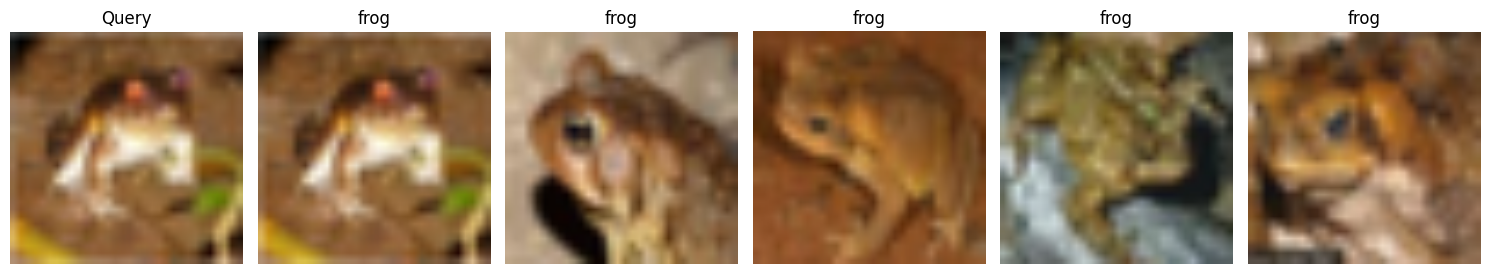

In [42]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

# Show query image
axes[0].imshow(query_img_display.permute(1, 2, 0))
axes[0].set_title("Query")
axes[0].axis('off')

# Show top 5 similar images
for i, idx in enumerate(ids):
    match_img, match_label = dataset[idx]
    match_img = unnorm(match_img).clamp(0, 1)
    axes[i + 1].imshow(match_img.permute(1, 2, 0))
    axes[i + 1].set_title(dataset.classes[match_label])
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()